# Mesh Generation with FloPy

In this notebook we'll cover how to build Structured and Unstructured Meshes (Grids) with FloPy for use in MODFLOW models. 

This notebook will start with generating a simple Structured Grid and we will use this grid object to begin developing Unstructured Meshes. The Unstructured Meshes we'll generate include:

   - Local Grid Refinement (LGR): A locally refined mesh that can be subsetted into a second model within a MODFLOW simulation
   - Quadtree Mesh: A mesh with a four fold (quad) refinement for each grid cell in a given refinement area
   - Triangular Mesh: A triangular mesh generated using Delaunay triangulation
   - Voronoi Mesh: A mesh generated from the connected centers of the Delaunay triangulation circumcircles


In [ ]:
import flopy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

from flopy.plot import PlotMapView
from flopy.discretization import StructuredGrid, VertexGrid
from flopy.utils.lgrutil import Lgr
from flopy.utils.gridgen import Gridgen
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.rasters import Raster
from flopy.utils.gridintersect import GridIntersect

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

## Creating a structured (rectilinear) grid

This activity will start by creating a simple sturctured (rectilinear) grid from a 1/3 arc second Digital Elevation Model of the Sagehen Creek watershed as an illustration of how we can create an initial mesh that can be used to develop a model from.

Load the Digital Elevation Model and visualize it

In [ ]:
dem = Path("../data/sagehen_geospatial/dem.img")
rstr = Raster.load(dem)
rstr.plot();

Get the DEM boundaries

In [ ]:
xmin, xmax, ymin, ymax = rstr.bounds

And begin developing an initial mesh for the model

In [ ]:
dx = dy = 100
lx = xmax - xmin
ly = ymax - ymin
nlay = 1
nrow = int(np.floor(ly / dy))
ncol = int(np.floor(lx / dx))
delc = np.full((nrow,), dx)
delr = np.full((ncol,), dy)

Finally create a fake top, bottom, and idomain for the model for now. These will be updated in a subsequent step.

In [ ]:
top = np.ones((nrow, ncol))
botm = np.zeros((nlay, nrow, ncol))
idomain = np.ones((nlay, nrow, ncol), dtype=int)

And now we can generate a `StructuredGrid` object that can be used for developing model inputs

In [ ]:
# live code

We can plot our `SturcturedGrid` object over the existing raster data to check that it is correctly orientied in space

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
rstr.plot(ax=ax)
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_grid(lw=0.5);

### Resampling data to finish creating our initial grid.

Once we have an initial grid, raster and vector data can be resampled or intersected with the grid to begin building a model domain. Although the focus of this notebook is to generate different types of meshes for modeling, the resampling and intersection process in this notebook can be applied many different data types and be used to generate boundary conditions within a MODFLOW model.

#### Raster resampling
We'll use FloPy's built in raster resampling method to generate values for land surface elevation (`top`) using the existing `StructuredGrid` object. For more information on raster resampling, please see this [example](https://flopy.readthedocs.io/en/latest/Notebooks/raster_intersection_example.html)

In [ ]:
top = rstr.resample_to_grid(
    sgrid,
    rstr.bands[0],
    method="min",
    extrapolate_edges=True
)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
pmv = PlotMapView(modelgrid=sgrid)
pc = pmv.plot_array(top)
pmv.plot_grid(lw=0.5)
plt.colorbar(pc, shrink=0.7);

#### Vector (shapefile) intersection

We can also intersect lines, points, and polygons with an existing modelgrid object. In this example, we'll load up the watershed boundary and get the active and inactive areas of the grid. For more information on intersecting shapefiles with a modelgrid/model see this [example](https://flopy.readthedocs.io/en/latest/Notebooks/grid_intersection_example.html)

In [ ]:
watershed = Path("../data/sagehen_geospatial/watershed_boundary.shp")
gdf = gpd.read_file(watershed)

fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(ax=ax);

Doing the intersection

In [ ]:
ix = GridIntersect(sgrid, method="vertex")
rowcol = ix.intersect(gdf.geometry.values[0], contains_centroid=True)["cellids"]
rowcol

In [ ]:
row, col = list(zip(*rowcol))

Building idomain from the intersection

In [ ]:
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
idomain[:, row, col] = 1

Putting it all together into a `StructuredGrid`

In [ ]:
sgrid = StructuredGrid(
    delc=sgrid.delc,
    delr=sgrid.delr,
    top=top,
    botm=sgrid.botm,
    idomain=idomain,
    nlay=sgrid.nlay,
    nrow=sgrid.nrow,
    ncol=sgrid.ncol,
    xoff=sgrid.xoffset,
    yoff=sgrid.yoffset,
    crs=sgrid.crs
)
sgrid

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
pmv = PlotMapView(modelgrid=sgrid)
pc = pmv.plot_array(sgrid.top)
ib = pmv.plot_inactive()
pmv.plot_grid(lw=0.5)
plt.colorbar(pc, shrink=0.7);

Because this is a watershed, we can also overlay a shapefile of the streams and get the stream cells using `GridIntersect`

In [ ]:
streams = Path("../data/sagehen_geospatial/streams.shp")
stgdf = gpd.read_file(streams)
stgdf.head()

In [ ]:
rowcols = []
ix = GridIntersect(sgrid, method="vertex")
for geom in stgdf.geometry.values:
    rcs = ix.intersects(geom)["cellids"]
    rowcols.extend(list(rcs))

In [ ]:
row, col = list(zip(*rowcols))
strms = np.zeros((nrow, ncol))
strms[row, col] = 1
strms

Plot the intersection results

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_array(sgrid.top, cmap="viridis")
pmv.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.5)
stgdf.plot(ax=ax)
plt.colorbar(pc, shrink=0.7);

Information from the grid we've created here can now be used for generating more complex meshes.

## Local Grid Refinement (LGR) mesh

A Local Grid Refinement (LGR) mesh can be created in an area of interest to get finer discretization than the existing/surrounding mesh. FloPy's `Lgr` utility, creates the refined mesh as a seperate modelgrid, and calculates the exchanges between the multi-model simulation mesh that results from refinement. 

The `Lgr` utility has a number of input parameters:
   - `nlayp`: the number of parent model layers
   - `nrowp`: the number of parent model rows
   - `ncolp`: the number of parent model columns
   - `delrp`: the parent model delr array
   - `delcp`: the parent model delc array
   - `topp`: the parent model top array
   - `botmp`: the parent model botm array
   - `idomainp`: an idomain array that is used to create the child grid. Values of 1 indicate parent model cells, values of 0 indicate child model cells. The child model must be a rectangular region that is continuous.
   - `ncpp`: number of child cells along the face of a parent cell
   - `ncppl`: number of child cells per parent layer
   - `xllp`: (optional) x location of parent grid lower left corner
   - `yllp`: (optional) y-location of parent grid lower left corner

**Load up the refinement area polygon**

In [ ]:
lgr_poly = Path("../data/sagehen_geospatial/lgr_bound.shp")
lgr_gdf = gpd.read_file(lgr_poly)

Plot it to see if it lines up properly with our model

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_array(sgrid.top, cmap="viridis")
pmv.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.5)
stgdf.plot(ax=ax)
lgr_gdf.plot(ax=ax, alpha=0.5)
plt.colorbar(pc, shrink=0.7);

Creating the parent/child idomainp array for `Lgr` using `GridIntersect`

In [ ]:
lgr_gdf

In [ ]:
idomainp = np.ones(sgrid.shape, dtype=int)

ix = GridIntersect(sgrid, method="vertex")
rowcol = ix.intersect(lgr_gdf.geometry.values[0], contains_centroid=True)["cellids"]
crow, ccol = list(zip(*rowcol))
idomainp[:, crow, ccol] = 0

Creating the `Lgr` object/child grid

In [ ]:
lgr = Lgr(
    nlayp=sgrid.nlay,
    nrowp=sgrid.nrow,
    ncolp=sgrid.ncol,
    delrp=sgrid.delr,
    delcp=sgrid.delc,
    topp=sgrid.top,
    botmp=sgrid.botm,
    idomainp=idomainp,
    ncpp=2,
    xllp=sgrid.xoffset,
    yllp=sgrid.yoffset
)

Get a `StructuredGrid` of the child model

In [ ]:
childgrid = lgr.child.modelgrid

Resample top elevations to the child grid

In [ ]:
childtop = rstr.resample_to_grid(
    childgrid,
    band=rstr.bands[0],
    method="min"
)
print(childtop.shape)
print(childgrid.shape)

Reset the top elevations in the `childgrid` object

In [ ]:
childgrid._top = childtop

Intersect streams with the Child mesh to define stream cells

In [ ]:
ix = GridIntersect(childgrid, method="vertex")
cstrmcells = []
for geom in stgdf.geometry.values:
    rcs = ix.intersects(geom)["cellids"]
    if len(rowcol) > 0:
        cstrmcells.extend(list(rcs))

cstrms = np.zeros((childgrid.nrow, childgrid.ncol), dtype=int)
row, col = list(zip(*cstrmcells))
cstrms[row, col] = 1

And now we can visualize the new LGR mesh

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
vmin, vmax = np.min(sgrid.top), np.max(sgrid.top)

pmvp = PlotMapView(modelgrid=sgrid, ax=ax)
ptop = sgrid.top.copy()
ptop[crow, ccol] = np.nan
strms[crow, ccol] = np.nan
pc = pmvp.plot_array(ptop, cmap="viridis", vmin=vmin, vmax=vmax)
pmvp.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmvp.plot_inactive()
pmvp.plot_grid(lw=0.3)
stgdf.plot(ax=ax)

pmvc = PlotMapView(modelgrid=childgrid, ax=ax, extent=sgrid.extent)
pmvc.plot_array(childtop, cmap="viridis", vmin=vmin, vmax=vmax)
pmvc.plot_array(cstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmvc.plot_grid(lw=0.3)
plt.colorbar(pc, shrink=0.7);

## Quadtree Mesh

A quadtree mesh is an unstructured refinement to a rectilinear modelgrid. In a quadtree mesh each node is split into 4 child nodes per level of refinement. The figure below is from [Lien and others, 2019](https://pubs.usgs.gov/of/2014/1109/pdf/ofr2014-1109.pdf) and shows multiple levels of recursive refinement.

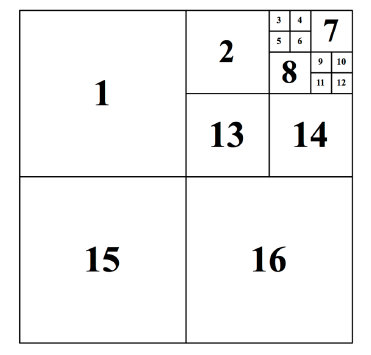

For this example, we will be using GRIDGEN and the FloPy utility `Gridgen` to create quadtree refinement around the streams in our example.

In [ ]:
gridgen_dir = Path("../data/sagehen_gridgen")
gridgen_dir.mkdir(exist_ok=True)

The `Gridgen` class a number of input parameters and further documentation/examples of the class can be found [here](https://flopy.readthedocs.io/en/latest/Notebooks/gridgen_example.html). For our example, we will be refining the area around the stream channels.

In [ ]:
g = Gridgen(sgrid, model_ws=gridgen_dir)
for geom in stgdf.geometry.values:
    xy = list(zip(*geom.coords.xy))
    g.add_refinement_features([xy,], "line", 2, range(1))

In [ ]:
g.build()

After gridgen builds the mesh, it can be used to create a `VertexGrid` (or DISV) that represents the basin

In [ ]:
gridprops = g.get_gridprops_disv()
gridprops.pop("nvert")

quadgrid = VertexGrid(**gridprops)
quadgrid.extent

Resample top elevations to the quadtree mesh and intersect the basin boundary and stream vectors

In [ ]:
# create the top array
top = rstr.resample_to_grid(
    quadgrid,
    band=rstr.bands[0],
    method="min"
)
quadgrid._top = top

In [ ]:
# create the idomain array
idomain = np.zeros(quadgrid.shape, dtype=int)
ix = GridIntersect(quadgrid, method="vertex")
nodes = ix.intersect(gdf.geometry.values[0], contains_centroid=True)["cellids"]
idomain[:, list(nodes)] = 1
quadgrid._idomain = idomain

In [ ]:
# create an array of stream cells
qstr = []
ix = GridIntersect(quadgrid, method="vertex")
for geom in stgdf.geometry.values:
    nodes = ix.intersects(geom)["cellids"]
    qstr.extend(list(nodes))

In [ ]:
qstrms = np.zeros((quadgrid.ncpl,), dtype=int)
qstrms[qstr] = 1

Plot the quadtree mesh with top elevations and streams

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

pmv = PlotMapView(modelgrid=quadgrid)
pc = pmv.plot_array(quadgrid.top)
pmv.plot_array(qstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.3)
stgdf.plot(ax=ax)
plt.colorbar(pc, shrink=0.7);

## Triangular Mesh

An unstructured/vertex based triangular mesh can be generated using the code "triangle"([Shewchuk, 2002](https://www.sciencedirect.com/science/article/pii/S0925772101000475)). And the FloPy utility, `Triangle` that creates inputs for and translates the outputs from "triangle". 

For this example, we will be using triangle to generate a mesh and add refinement around the streams.

In [ ]:
tri_dir = Path("../data/sagehen_tri")
tri_dir.mkdir(exist_ok=True)

For this example, we will use the watershed boundary and create a dissovled polygon of stream segments to generate our triangulation regions.

Start by creating a geodataframe of the active watershed area defined by our `StructuredGrid`

In [ ]:
sgdf = sgrid.geo_dataframe
sgdf.head()

Filter the geodataframe for only active cells (idomain > 0)

In [ ]:
sgdf["idomain"] = sgrid.idomain[0].ravel()
sgdf = sgdf[sgdf.idomain > 0]
sgdf.head()

And dissolve the active area into a single polygon

In [ ]:
sgdf = sgdf.dissolve()
sgdf.plot();

Now to dissolve and buffer the stream network into a single polygon that defines our area of refinement

In [ ]:
bufgdf = stgdf.dissolve()
bufgdf["geometry"] = bufgdf.geometry.buffer(50, cap_style=2, join_style=3)
bufgdf.plot();

These two polygons can now be used to generate a triangular mesh with the `Triangle` utility. The `Triangle` class has a number of input parameters. For more detail on the inputs and additional examples please see this [notebook](https://flopy.readthedocs.io/en/latest/Notebooks/dis_voronoi_example.html)

In [ ]:
# define point locations within the watershed and the stream for adding regions
wsloc = (220000, 4368000)
stloc = (219250, 4370000)

In [ ]:
tri = Triangle(angle=30, model_ws=tri_dir)

# define the model/mesh boundary
tri.add_polygon(sgdf.geometry.values[0])
tri.add_region(wsloc, 0, maximum_area=100*300)

# define the stream refinement area
tri.add_polygon(bufgdf.geometry.values[0])
tri.add_region(stloc, 1, maximum_area=40*40)

In [ ]:
tri.build()

Visualize the triangular mesh

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
tri.plot(ax=ax)
stgdf.plot(ax=ax);

Create a `VertexGrid` from the triangular mesh and resample the land surface elevations

In [ ]:
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
ncpl = len(cell2d)
nlay = 1
idomain = np.ones((nlay, ncpl), dtype=int)

# set fake values for top and botm for now)
top = np.ones((ncpl,))
botm = np.zeros((nlay, ncpl))

In [ ]:
trigrid = VertexGrid(
    vertices=vertices,
    cell2d=cell2d,
    ncpl=ncpl,
    nlay=nlay,
    idomain=idomain,
    top=top,
    botm=botm,
    crs="EPSG:26911"
)
trigrid.extent

In [ ]:
top = rstr.resample_to_grid(
    trigrid,
    band=rstr.bands[0],
    method="min",
    extrapolate_edges=True
)
trigrid._top = top

And perform intersection to identify stream cells

In [ ]:
tristr = []
ix = GridIntersect(trigrid, method="vertex")
for geom in stgdf.geometry.values:
    nodes = ix.intersects(geom)["cellids"]
    tristr.extend(list(nodes))

tristrms = np.zeros((trigrid.ncpl,), dtype=int)
tristrms[tristr] = 1

Now to plot up the triangular grid

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

pmv = PlotMapView(modelgrid=trigrid)
pc = pmv.plot_array(trigrid.top)
pmv.plot_array(tristrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.3)
stgdf.plot(ax=ax)
plt.colorbar(pc, shrink=0.7);

## Voronoi Mesh

A voronoi mesh can be generated from the circumcirle centroids of each triangular node in a Delaunay triangulation. The centroid of each circumcirle produces a vertex for the voronoi mesh and these vertices are connected via adjacency relationships of the triangulation. 

FloPy has a built in utility `VoronoiGrid` that produces voronoi meshes from Delaunay triangulations. For more information and additional examples on `VoronoiGrid`'s usage, see this [notebook](https://flopy.readthedocs.io/en/latest/Notebooks/dis_voronoi_example.html)

To generate a voronoi mesh, we just need to pass our triangluation object (`tri`) to the `VoronoiGrid` utility

In [ ]:
vor = VoronoiGrid(tri)

Build a `VertexGrid`

In [ ]:
gridprops = vor.get_gridprops_vertexgrid()
nlay = 1
idomain = np.ones(gridprops["ncpl"], dtype=int)
top = idomain.copy().astype(float)
botm = np.zeros((nlay, gridprops["ncpl"]))

In [ ]:
vorgrid = VertexGrid(
    nlay=nlay,
    idomain=idomain,
    top=top,
    botm=botm,
    **gridprops
)

Resample the land surface elevation from the DEM to the voronoi grid

In [ ]:
top = rstr.resample_to_grid(
    vorgrid,
    band=rstr.bands[0],
    method="min",
    extrapolate_edges=True
)
vorgrid._top = top

Identify stream cells with `GridIntersect`

In [ ]:
vorst = []
ix = GridIntersect(vorgrid, method="vertex")
for geom in stgdf.geometry.values:
    nodes = ix.intersects(geom)["cellids"]
    vorst.extend(list(nodes))

vorstrms = np.zeros((vorgrid.ncpl,), dtype=int)
vorstrms[vorst] = 1

Finally plot the voronoi mesh with the DEM data and stream locations

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

pmv = PlotMapView(modelgrid=vorgrid)
pc = pmv.plot_array(vorgrid.top)
pmv.plot_array(vorstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.3)
stgdf.plot(ax=ax)
plt.colorbar(pc, shrink=0.7);

Now we can plot all of the meshes we produced side by side for comparison!

In [ ]:
from matplotlib.gridspec import GridSpec
from flopy.plot import styles

with styles.USGSMap():
    fig = plt.figure(figsize=(10, 12))
    gs = GridSpec(14, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0:4, 0])
    ax1 = fig.add_subplot(gs[0:4, 1])
    ax2 = fig.add_subplot(gs[5:9, 0])
    ax3 = fig.add_subplot(gs[5:9, 1])
    ax4 = fig.add_subplot(gs[10:, 0])
    ax5 = fig.add_subplot(gs[11, 1], )

    # structured grid
    pmv = PlotMapView(modelgrid=sgrid, ax=ax0)
    pmv.plot_array(sgrid.top, cmap="viridis")
    pmv.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.3)
    stgdf.plot(ax=ax0)
    styles.heading(ax0, "     A. ", heading="Structured Grid")
    
    # LGR grid
    pmvp = PlotMapView(modelgrid=sgrid, ax=ax1)
    ptop = sgrid.top.copy()
    ptop[crow, ccol] = np.nan
    strms[crow, ccol] = np.nan
    pc = pmvp.plot_array(ptop, cmap="viridis", vmin=vmin, vmax=vmax)
    pmvp.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmvp.plot_inactive()
    pmvp.plot_grid(lw=0.3)
    stgdf.plot(ax=ax1)
    
    pmvc = PlotMapView(modelgrid=childgrid, ax=ax1)
    pmvc.plot_array(childtop, cmap="viridis", vmin=vmin, vmax=vmax)
    pmvc.plot_array(cstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmvc.plot_grid(lw=0.3)
    styles.heading(ax1, "     B. ", heading="LGR Grid")

    # Quadtree grid
    pmv = PlotMapView(modelgrid=quadgrid, ax=ax2)
    pc = pmv.plot_array(quadgrid.top)
    pmv.plot_array(qstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.2)
    stgdf.plot(ax=ax2)
    styles.heading(ax2, "     C. ", heading="Quadtree Grid")

    # Triangular grid
    pmv = PlotMapView(modelgrid=trigrid, ax=ax3)
    pc = pmv.plot_array(trigrid.top)
    pmv.plot_array(tristrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.3)
    stgdf.plot(ax=ax3)
    styles.heading(ax3, "     D. ", heading="Triangular Grid")

    # Voronoi grid
    pmv = PlotMapView(modelgrid=vorgrid, ax=ax4)
    pc = pmv.plot_array(vorgrid.top)
    pmv.plot_array(vorstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.3)
    stgdf.plot(ax=ax4)
    styles.heading(ax4, "     E. ", heading="Voronoi Grid")

    # colorbar
    ax5.spines[["left", "right", "top", "bottom"]].set_visible(False)
    fig.colorbar(pc, cax=ax5, orientation="horizontal", label="Land surface elevation, in meters")

### More information 
For more inforation and and examples on how to use the utilities presented in this notebook please see:

#### Examples
   - [FloPy Examples Gallery](https://flopy.readthedocs.io/en/latest/examples.html)

#### API reference
   - [FloPy utils API reference](https://flopy.readthedocs.io/en/latest/code.html#flopy-utilities)
   - [FloPy lgrutil API reference](https://flopy.readthedocs.io/en/latest/source/flopy.utils.lgrutil.html)
   - [FloPy gridgen API reference](https://flopy.readthedocs.io/en/latest/source/flopy.utils.gridgen.html)
   - [FloPy triangle API reference](https://flopy.readthedocs.io/en/latest/source/flopy.utils.triangle.html)
   - [FloPy voronoi API reference](https://flopy.readthedocs.io/en/latest/source/flopy.utils.voronoi.html)